## Quantitative QC by CV calculation
The data used in this notebook is lymphocyte data for one patient's B cells and T cells. We use this data to show the proteome variation between the cell types. Here, we calculate CVs to show the quality of the data.

After calculating CVs, we calculate Spearman correlation among replicates.


First, we import our loader module. This brings the functions defined there (in our repository at ~/load_data.py) into scope so we can use them in this script. Then we can load our data and store it as <code>data</code>.

Calling <code>head</code> shows the first several lines of the dataframe, which provides an idea of the type of data present and the structure of the dataframe.

In [1]:
import load_data
data_raw = load_data.load_FragPipe()
data_raw.head()

,Subject1_B_cells_June_C_10 Total Intensity,Subject1_B_cells_June_C_11 Total Intensity,Subject1_B_cells_June_C_12 Total Intensity,Subject1_B_cells_June_C_13 Total Intensity,Subject1_B_cells_June_C_9 Total Intensity,Subject1_T_cells_June_D_10 Total Intensity,Subject1_T_cells_June_D_11 Total Intensity,Subject1_T_cells_June_D_12 Total Intensity,Subject1_T_cells_June_D_13 Total Intensity,Subject1_T_cells_June_D_9 Total Intensity
Protein ID,,,,,,,,,,
A0A0B4J2D5,1206607.50,1882145.4,2417132.20,3093545.2,1701011.9,301610.60,0.00,249601.9,0.0,277209.10
A0AVT1,584806.90,872883.0,1135346.80,543014.9,2131811.8,0.00,805666.10,0.0,0.0,425896.38
A0FGR8,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00
A6NHR9,655176.10,0.0,3419854.50,0.0,0.0,105097.76,0.00,0.0,0.0,0.00
A8MWD9,696141.44,1213763.9,850701.44,1364050.2,633904.0,0.00,464729.78,0.0,0.0,446894.66


Now we normalize across runs. Note that following median normalization, we reverse the log2, leaving the data aligned between runs but allowing the most typical coefficient variation calculation.

In [2]:
from numpy import nan
from numpy import log2
from statistics import median

data_log2 = log2(data_raw.replace(0,nan))
#global_median = median(data_log2.apply(lambda series: median(series.dropna())))
data_log2_normalized = data_log2.apply(lambda series: series-median(series.dropna()))#+global_median)
data = data_log2_normalized.apply(lambda series: 2**series)

Next, we select the proteins that are measured in at least three samples from each group, allowing the calculations to proceed without imputed zero-handling.

In [3]:
import data_utils    
indecies = data.apply(data_utils.check_three_of_each_type, axis=1)
data = data[indecies]
#data.head()

Finally, we will calculate the coeffients of variation for each protein within each of the two cell types. 

In [4]:
from scipy.stats import variation
from statistics import mean
import pandas as pd
from numpy import isnan

In [5]:
cell_types = ["1_B", "1_T"]
CVs = {}
for population in cell_types:
    cells_in_population = list(s for s in data.columns.values.tolist() if population in s)
    data_by_type = data[cells_in_population]
    #now we have a dataframe with just one subpopulation
    #Call variation function
    var = data_by_type.apply(variation, axis=1, nan_policy='omit')
    CVs[population] = var
    
    #Here we report an overview
    print (population)
    print ('Mean CV:\t',mean(var))
    print ('Min CV: \t',min(var))
    print ('Max CV: \t',max(var))
    print ('nan:    \t',len([i for i in var if isnan(i)]))
    print ('Zero:    \t',len([i for i in var if i==0]))
    var_under_20 = len([i for i in var if i < .2])
    var_under_10 = len([i for i in var if i < .1])
    count = len(var)#len([i for i in var if i!=0])
    print ('Under 10%:\t',var_under_10,'\t{0:.2f}'.format(var_under_10/count))
    print ('Under 20%:\t',var_under_20,'\t{0:.2f}'.format(var_under_20/count))
    print (count)
    print ()
    

CVs = pd.DataFrame.from_dict(CVs)    

1_B
Mean CV:	 0.3068827334548042
Min CV: 	 0.03160106588990182
Max CV: 	 1.2833325650885115
nan:    	 0
Zero:    	 0
Under 10%:	 44 	0.05
Under 20%:	 363 	0.37
970

1_T
Mean CV:	 0.24351053941538708
Min CV: 	 0.01488785893051874
Max CV: 	 1.8339260807341373
nan:    	 0
Zero:    	 0
Under 10%:	 184 	0.19
Under 20%:	 535 	0.55
970



Next, we will visualize the data, which shows that the majority of proteins have small coefficients of variation.

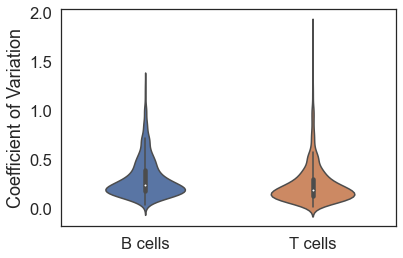

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
figure = sns.violinplot(data=CVs, width=.5)
figure.set_ylabel("Coefficient of Variation")
figure.set_xticklabels(['B cells', 'T cells'])
#plt.savefig("CV_FP.png", dpi=300)

plt.show()

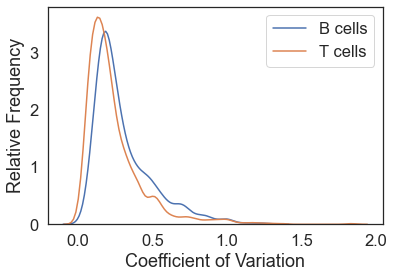

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)

sns.set_style("white")
figure = sns.distplot(CVs['1_B'], hist = False, label='B cells')#, width=.5)
figure = sns.distplot(CVs['1_T'], hist = False, label='T cells')#, width=.5)
figure.set_ylabel("Relative Frequency")
figure.set_xlabel("Coefficient of Variation")

figure.legend(['B cells', 'T cells'])
plt.show()

Here we summarize the CVs overall. Note that the CVs were calculated within types and so still represent technical variability, not variation between cell types.

In [8]:
var = CVs.values.flatten()

print ('Mean CV:\t',mean(var))
print ('Min CV: \t',min(var))
print ('Max CV: \t',max(var))
print ('nan:    \t',len([i for i in var if isnan(i)]))
print ('Zero:    \t',len([i for i in var if i==0]))
    
var_under_20 = len([i for i in var if i < .2])
var_under_10 = len([i for i in var if i < .1])
count = len(var)#len([i for i in var if i!=0])
print ('Under 10%:\t',var_under_10,'\t{0:.2f}'.format(var_under_10/count))
print ('Under 20%:\t',var_under_20,'\t{0:.2f}'.format(var_under_20/count))

Mean CV:	 0.2751966364350956
Min CV: 	 0.01488785893051874
Max CV: 	 1.8339260807341373
nan:    	 0
Zero:    	 0
Under 10%:	 228 	0.12
Under 20%:	 898 	0.46


This shows accuracy in repeatedly characterizing each cell type.

### Correlation coefficient
Next, we show reproducibility of the replicates by Spearman correlation coefficient.

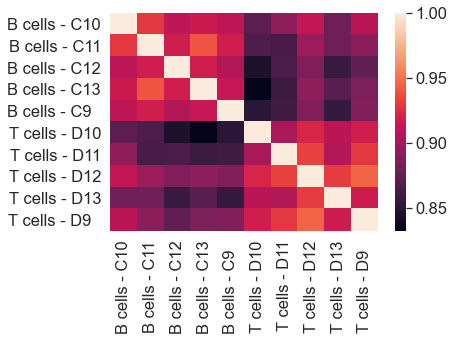

In [9]:
correlations = data.corr(method="spearman")

labels=['B cells - C10','B cells - C11',
                    'B cells - C12','B cells - C13',
                    'B cells - C9  ','T cells - D10',
                    'T cells - D11','T cells - D12',
                    'T cells - D13','T cells - D9  ']

correlations.index=labels
correlations.columns=labels

import numpy as np
mask = np.zeros(correlations.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

sns.heatmap(correlations)#, cmap = 'coolwarm', mask = mask)


#plt.savefig("data/FP_figures/correlations_heatmap_FP.png", dpi=300,
#            bbox_inches='tight')

In [10]:
#drop self-correlations of 1
for sample in correlations.columns:
        correlations[sample][sample]=nan
        
correlations

,B cells - C10,B cells - C11,B cells - C12,B cells - C13,B cells - C9,T cells - D10,T cells - D11,T cells - D12,T cells - D13,T cells - D9
B cells - C10,NaN,0.930392,0.910222,0.915851,0.911183,0.873152,0.893052,0.912194,0.879964,0.909776
B cells - C11,0.930392,NaN,0.918525,0.940529,0.919039,0.867447,0.864239,0.898044,0.880450,0.892210
B cells - C12,0.910222,0.918525,NaN,0.918891,0.906595,0.845539,0.866461,0.886506,0.858108,0.874863
B cells - C13,0.915851,0.940529,0.918891,NaN,0.913553,0.832875,0.860173,0.892704,0.871239,0.886033
B cells - C9,0.911183,0.919039,0.906595,0.913553,NaN,0.851526,0.861386,0.888364,0.856660,0.887773
T cells - D10,0.873152,0.867447,0.845539,0.832875,0.851526,NaN,0.903337,0.922863,0.909406,0.918837
T cells - D11,0.893052,0.864239,0.866461,0.860173,0.861386,0.903337,NaN,0.933883,0.906328,0.930204
T cells - D12,0.912194,0.898044,0.886506,0.892704,0.888364,0.922863,0.933883,NaN,0.931877,0.945432
T cells - D13,0.879964,0.880450,0.858108,0.871239,0.856660,0.909406,0.906328,0.931877,NaN,0.916550
T cells - D9,0.909776,0.892210,0.874863,0.886033,0.887773,0.918837,0.930204,0.945432,0.916550,NaN


Here we split the dataset by cell type and perform the same correlation test. We then take the average correlation between replicates.

In [11]:
corr_type = {}
corr_summary={}
for cell_type in cell_types:
    
    cells_of_type = list(s for s in data.columns.values.tolist() if cell_type in s)
    data_by_type = data[cells_of_type]
    corr_of_type = data_by_type.corr(method='spearman')
    
    #drop self-correlations of 1
    for sample in corr_of_type.columns:
        corr_of_type[sample][sample]=nan
    
    corr_type[cell_type] = corr_of_type
    
    #take the average of the correlations between a sample and  
    #    the other samples of the same type
    summary = corr_of_type.apply(lambda x: mean(x.dropna()))
    corr_summary[cell_type] = mean(summary)
    
    print (cell_type,"average correlation:\t",mean(summary))

1_B average correlation:	 0.9184781628021973
1_T average correlation:	 0.9218716964170901


With the average correlation between each set of replicates, we now average them to get the overall average. 

In [12]:
mean(corr_summary.values())

0.9201749296096438